In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_edge_approx(edge_image, edge_approximations):
    # Plot des Edge-Bildes
    plt.imshow(edge_image, cmap='gray')

    # Plot der approximierten Kanten als Linien mit blauer Farbe
    for edge_approx in edge_approximations:
        x_approx = edge_approx[:, :, 0].flatten()
        y_approx = edge_approx[:, :, 1].flatten()
        plt.plot(x_approx, y_approx, color='blue')

        # Plot der Eckpunkte als rote Punkte
        plt.plot(x_approx, y_approx, 'ro')

    plt.title('Edge Approximation')

    # Anpassung der Achsenskalierung
    plt.axis('scaled')

    # Anzeigen des Diagramms
    plt.show()

In [3]:
def plot_edge_approx2(edge_image, edge_points, feed_points):
    # Plot des Edge-Bildes
    plt.imshow(edge_image, cmap='gray')

    # Plot der approximierten Kanten als Linien mit blauer Farbe
    for i in range(0, len(edge_points)):
        edge_approx = edge_points[i]
        feed_point = feed_points[i]
        
        # Plot G1
        segment_ended = False
        g1_segments = []
        g1_segment_points = []
        for j, value in enumerate(feed_point):
            if segment_ended:
                g1_segment_points.append(edge_approx[j-1])
                segment_ended = False
                
            if value:
                g1_segment_points.append(edge_approx[j])
            elif len(g1_segment_points) != 0:
                g1_segments.append(np.array(g1_segment_points))
                g1_segment_points = []
                segment_ended = True
        if len(g1_segment_points) != 0:
            g1_segments.append(np.array(g1_segment_points))

        for g1_points in g1_segments:
            # Plot G1 Linien
            g1_x_approx = g1_points[:, :, 0].flatten()
            g1_y_approx = g1_points[:, :, 1].flatten()
            plt.plot(g1_x_approx, g1_y_approx, color='red')

            # Plot der Eckpunkte als rote Punkte
            plt.plot(g1_x_approx, g1_y_approx, 'ro')

        # Plot G0
        g0_points = np.array([np.array([edge_approx[j-1], edge_approx[j]]) for j in [i for i, value in enumerate(feed_point) if value == False]])
        if g0_points.size != 0:
            for g0_point in g0_points:
                # Plot G0 Linien
                g0_x_approx = [g0_point[0][0][0], g0_point[1][0][0]]
                g0_y_approx = [g0_point[0][0][1], g0_point[1][0][1]]
                plt.plot(g0_x_approx, g0_y_approx, color='green', linestyle='--')

                # Plot der Eckpunkte als rote Punkte
                plt.plot(g0_point[1][0][0], g0_point[1][0][1], 'o', color='green', markersize=4)

    plt.title('Edge Approximation')

    # Anpassung der Achsenskalierung
    plt.axis('scaled')

    # Anzeigen des Diagramms
    plt.show()

In [4]:
def checkIfSegmentNotInUsedContours(segment_contour_points, used_contour_points):
    is_not_in = False
    for point in segment_contour_points:
        if not any(np.all(point == p) for p in used_contour_points):
            is_not_in = True
            break
    return is_not_in

def getContourApproximation2(edge_image, epsilon):
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    feed_points = []
    contour_segments = []
    k = 0
    for contour in contours:
        print(f'{k} \ {len(contours)}')
        k += 1

        approx = cv2.approxPolyDP(contour, epsilon, True)

        # print('contour', ','.join([str(k) for k in contour]), '\n')
        # print('approx', ','.join([str(k) for k in approx]), '\n')

        rescent_index = 0
        
        used_contour_points = None

        feed_point = []
        segment = []
        for i in range(len(approx)):
            if i == 0:
                start_point = approx[i][0]
                segment.append(np.array([start_point]))
                feed_point.append(True)
            end_point = approx[(i+1) % len(approx)][0]

            # Find Index
            indexes = np.where(np.all(contour == end_point, axis=(1, 2)))
            if indexes[0].size == 0:
                break

            # Get Index Position 
            amt_end_point_u_c = len(np.where(np.all(used_contour_points == end_point, axis=(1, 2)))[0]) if i != 0 else 0
            index = 0
            if amt_end_point_u_c <= indexes[0].size - 1:
                index = indexes[0][amt_end_point_u_c] + 1 if amt_end_point_u_c != len(contour) -1 else indexes[0][amt_end_point_u_c]
            else:
                index = indexes[0].max() + 1 if indexes[0].max() != len(contour) -1 else indexes[0].max()

            # Die Konturpunkte des Segments
            segment_contour_points = None
            if rescent_index == index:
                segment_contour_points = np.array([contour[index]])
            elif i == len(approx) - 1:
                segment_contour_points = np.concatenate((contour[rescent_index:], contour[:index]))
            elif rescent_index < index:
                segment_contour_points = contour[rescent_index: index]
            elif rescent_index > index:
                segment_contour_points = contour[index: rescent_index]

            # print('segment', ','.join([str(k) for k in segment_contour_points]))
            # print('used_contour_points', ','.join([str(k) for k in used_contour_points]) if i != 0 else used_contour_points)
            # print('recentIndex', rescent_index, 'index', index, 'end_point', end_point)
            # print('is in', checkIfSegmentNotInUsedContours(segment_contour_points, used_contour_points) if i != 0 else True)
            
            # Check if Contour Points are already used
            if checkIfSegmentNotInUsedContours(segment_contour_points, used_contour_points) if i != 0 else True:
                if i == 0:
                    used_contour_points = contour[rescent_index: index]
                else:
                    used_contour_points = np.concatenate((used_contour_points, contour[rescent_index: index]), axis=0)
                feed_point.append(True)
            else:
                # print('!!!!!!!! END !!!!!!!!!!')
                # break
                feed_point.append(False)
                # continue

            rescent_index = index + 1
            segment.append(np.array([end_point]))

        contour_segments.append(np.array(segment))
        feed_points.append(feed_point)

    return contour_segments, feed_points

## 1. Tests
---

0 \ 1
edge_points [[0 0]],[[0 9]],[[9 9]],[[9 0]],[[0 0]]
feed_points [[True, True, True, True, True]]


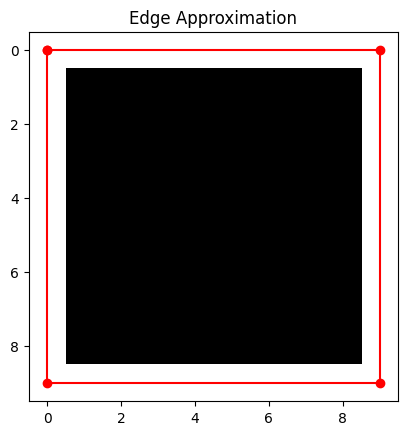

In [5]:
edge_image = np.array([
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

0 \ 1
edge_points [[0 0]],[[0 9]],[[9 9]],[[9 0]],[[4 5]],[[0 0]]


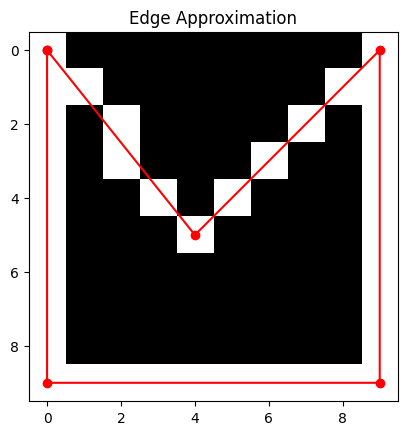

In [6]:
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255,   0,   0,   0,   0,   0,   0, 255, 255],
       [255,   0, 255,   0,   0,   0,   0, 255,   0, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 3)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
plot_edge_approx2(edge_image, edge_points, feed_points)

0 \ 1
edge_points [[0 0]],[[0 9]],[[9 9]],[[9 0]],[[9 1]],[[8 2]],[[7 2]],[[4 5]],[[0 1]],[[0 0]]
feed_points [[True, True, True, True, True, True, True, True, True, False]]


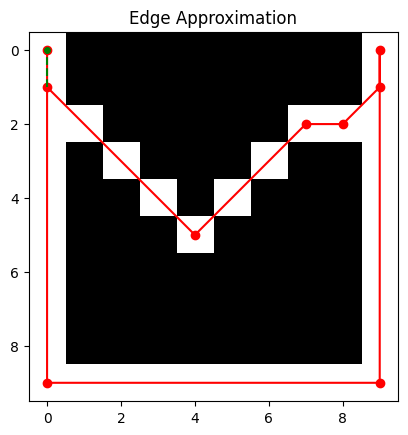

In [7]:
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255,   0,   0,   0,   0,   0, 255, 255, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

0 \ 1
edge_points [[0 0]],[[0 9]],[[9 9]],[[9 0]],[[4 5]],[[0 1]],[[0 0]]
feed_points [[True, True, True, True, True, True, False]]


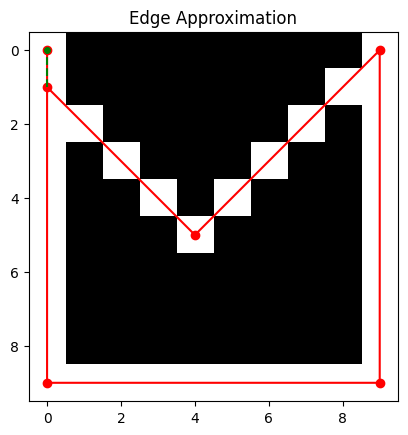

In [8]:
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0, 255, 255],
       [255, 255,   0,   0,   0,   0,   0, 255,   0, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

0 \ 1
edge_points [[0 0]],[[0 9]],[[9 9]],[[9 0]],[[9 4]],[[8 5]],[[1 5]],[[0 4]],[[0 0]]
feed_points [[True, True, True, True, False, True, True, False, False]]


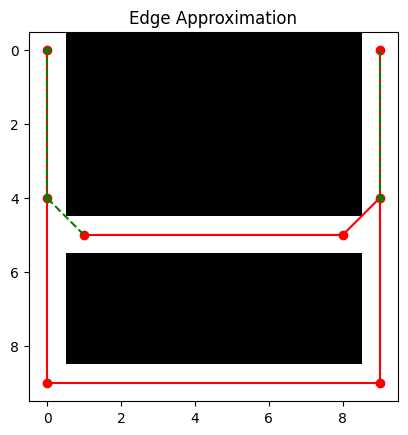

In [9]:
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

0 \ 1
edge_points [[1 0]],[[1 3]],[[2 4]],[[1 5]],[[2 6]],[[1 7]],[[2 8]],[[9 8]],[[9 0]],[[9 3]],[[8 4]],[[2 4]],[[1 3]],[[1 0]]
feed_points [[True, True, True, True, True, True, True, True, True, False, True, True, True, False]]


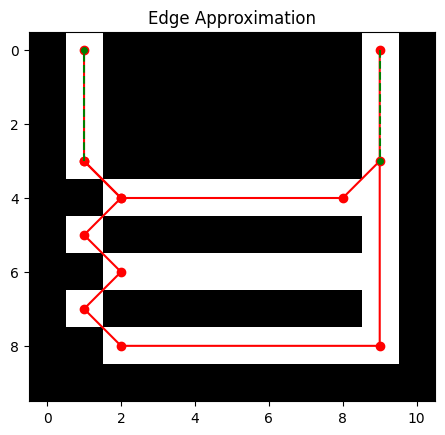

In [10]:
edge_image = np.array([
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 0)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

0 \ 1
edge_points [[0 0]],[[9 9]],[[0 0]]
feed_points [[True, True, True]]


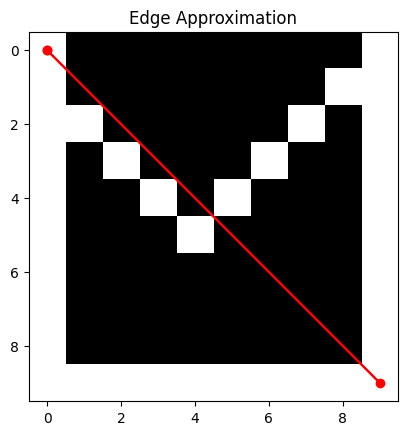

In [11]:
# Palidrom Problem
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0, 255, 255],
       [255, 255,   0,   0,   0,   0,   0, 255,   0, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation2(edge_image, 10)
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

In [12]:
import base64
preloaded_images = None
with open("../../preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Graustufenbild
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)

edge_image = cv2.Canny(gray, 50, 150)

In [13]:
edge_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [14]:
edge_points, feed_points = getContourApproximation2(edge_image, 5)

0 \ 1650
1 \ 1650
2 \ 1650
3 \ 1650
4 \ 1650
5 \ 1650
6 \ 1650
7 \ 1650
8 \ 1650
9 \ 1650
10 \ 1650
11 \ 1650
12 \ 1650
13 \ 1650
14 \ 1650
15 \ 1650
16 \ 1650
17 \ 1650
18 \ 1650
19 \ 1650
20 \ 1650
21 \ 1650
22 \ 1650
23 \ 1650
24 \ 1650
25 \ 1650
26 \ 1650
27 \ 1650
28 \ 1650
29 \ 1650
30 \ 1650
31 \ 1650
32 \ 1650
33 \ 1650
34 \ 1650
35 \ 1650
36 \ 1650
37 \ 1650
38 \ 1650
39 \ 1650
40 \ 1650
41 \ 1650
42 \ 1650
43 \ 1650
44 \ 1650
45 \ 1650
46 \ 1650
47 \ 1650
48 \ 1650
49 \ 1650
50 \ 1650
51 \ 1650
52 \ 1650
53 \ 1650
54 \ 1650
55 \ 1650
56 \ 1650
57 \ 1650
58 \ 1650
59 \ 1650
60 \ 1650
61 \ 1650
62 \ 1650
63 \ 1650
64 \ 1650
65 \ 1650
66 \ 1650
67 \ 1650
68 \ 1650
69 \ 1650
70 \ 1650
71 \ 1650
72 \ 1650
73 \ 1650
74 \ 1650
75 \ 1650
76 \ 1650
77 \ 1650
78 \ 1650
79 \ 1650
80 \ 1650
81 \ 1650
82 \ 1650
83 \ 1650
84 \ 1650
85 \ 1650
86 \ 1650
87 \ 1650
88 \ 1650
89 \ 1650
90 \ 1650
91 \ 1650
92 \ 1650
93 \ 1650
94 \ 1650
95 \ 1650
96 \ 1650
97 \ 1650
98 \ 1650
99 \ 1650
100 \ 1650

KeyboardInterrupt: 

In [ ]:
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)